<a href="https://colab.research.google.com/github/DoryGomez/Inteligencia_Artificial/blob/main/segmentacion_de_clientes_proy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from sklearn import metrics
#import warnings
#import sys
#if not sys.warnoptions:
 #   warnings.simplefilter("ignore")
np.random.seed(42)



In [92]:
datos = pd.read_csv('marketing_campaign.csv')

datos

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04/09/2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08/03/2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21/08/2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/02/2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19/01/2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13/06/2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10/06/2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25/01/2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24/01/2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [93]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [94]:
# Se revisa si hay nulls (vacios)
datos.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [95]:
#Se eliminan los valores Null o vacios
datos = datos.dropna()
print("El nuevo # de datos despues de eliminar los null es:", len(datos))

El nuevo # de datos despues de eliminar los null es: 2216


In [96]:
#valores de categorias para tener una mejor dea de la informacion
print("Categorias en  Marital_Status:\n", datos["Marital_Status"].value_counts())
print("\n\n")
print("Categorias en Education:\n", datos["Education"].value_counts())


Categorias en  Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64



Categorias en Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [97]:
#Reconstrucción de datos
#Edad de los clientes por año de nacimiento
datos["Age"]=2021-datos["Year_Birth"]
#data['Age'] = 2021 - data.Year_Birth.to_numpy()

#Total de gastos de cosas en categorias por cliente
datos["Spent"]=datos["MntWines"]+datos["MntFruits"]+datos["MntMeatProducts"]+datos["MntFishProducts"]+datos["MntSweetProducts"]+ datos["MntGoldProds"]

#Ajuste de situación de las parejas de la columna "Marital_Status"
datos["Marital_Status"]= datos["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone","Single":"Alone",})

#Indica la cantidad de niños por vivienda
datos["Children"]=datos["Kidhome"]+datos["Teenhome"]

#Total de personas en una casa
datos["Family_Size"] = datos["Marital_Status"].replace({"Alone": 1, "Partner":2})+ datos["Children"]

#Para indicar si son padres o no
datos["Is_Parent"] = np.where(datos.Children> 0, 1, 0)

#Segmenting education levels in three groups
datos["Education"]= datos["Education"].replace({"Basic":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate","2n Cycle":"Postgraduate", "PhD":"Postgraduate"})

#
#Se quitan categorias redundantes
# Se eliminan las categorias constantes (Z_CostContact & Z_Revenue) y las que no sirven para la segmentación y la clasificación (ID y Dt_Customer)
eliminar = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
datos = datos.drop(eliminar, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [98]:
#ahora quese tiene una mejor organización del dataset, se procede a observar los valores estadisticos de las categorias importantes: media,max, min, etc.
datos.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,128.000000,2525.000000,3.000000,5.000000,1.000000


In [99]:
#Se reducen datos por discrepancias como la edad y el ingreso
datos = datos[(datos["Age"]<90)]
datos = datos[(datos["Income"]<600000)]
print("El nuevo # total de datos es:", len(datos))

El nuevo # total de datos es: 2212


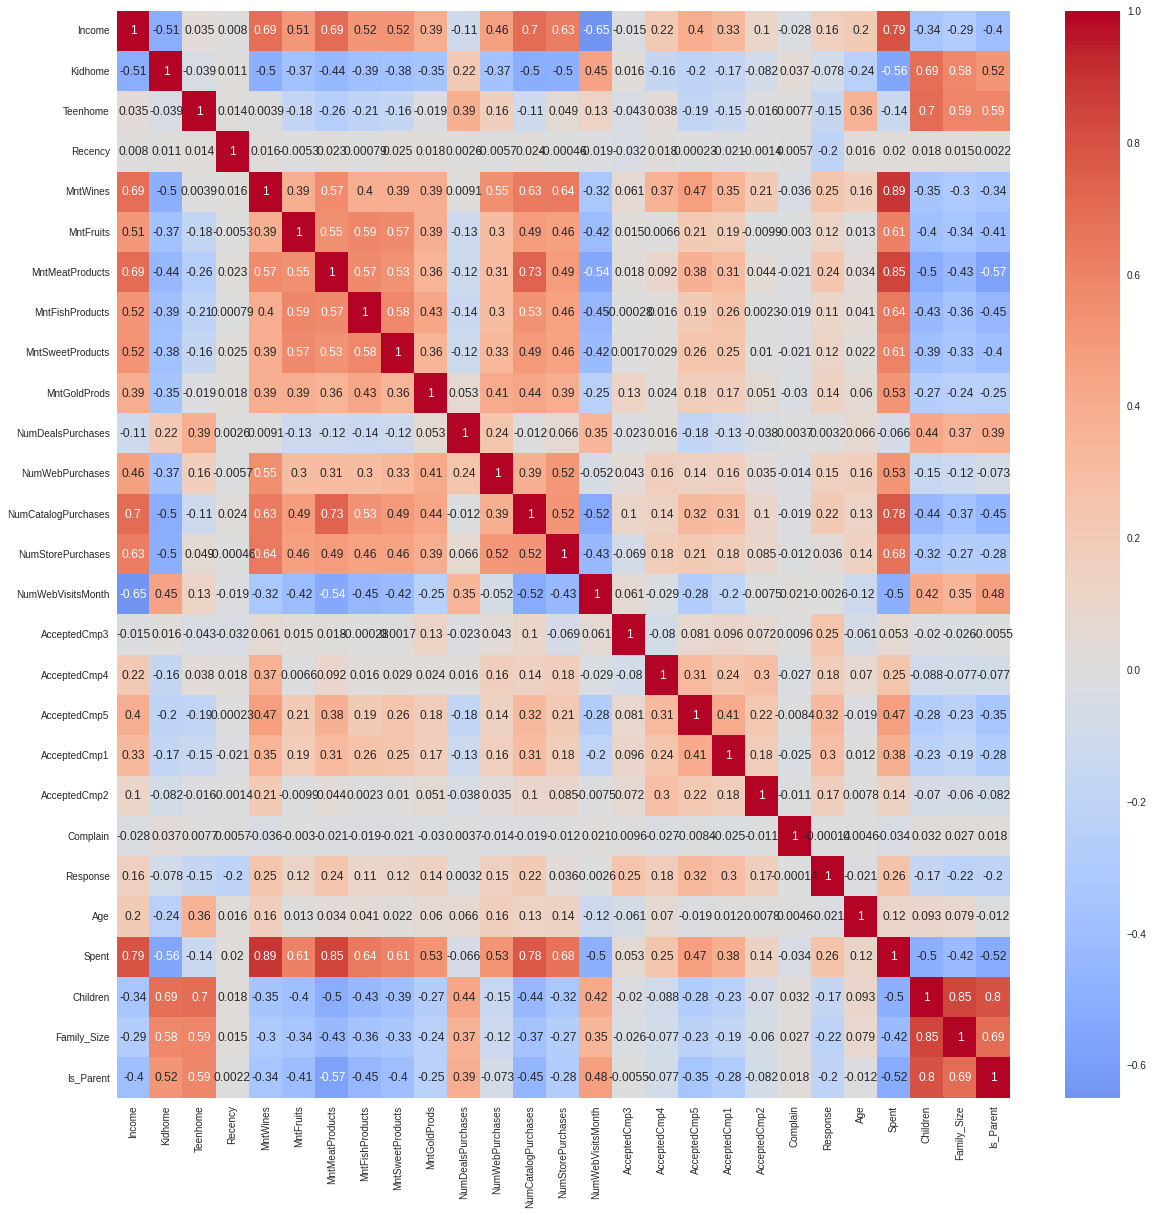

In [100]:
# se realiza la matriz de correlación de las clases
corrmat= datos.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)
plt.show()

In [101]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

In [102]:
#reoordenamiento de las columnas para mejor entendimiento
#order = [23,0,1,2,3,4,25,26,27,24,5,6,7,8,9,10,11,12,20,21,17,18,19,13,14,15,16,22]
order = [24,0,1,2,3,4,26,27,28,25,5,6,7,8,9,10,11,12,20,21,17,18,19,13,14,15,16,23]
datos = datos[[datos.columns[i] for i in order]]
datos.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Children,Family_Size,Is_Parent,Spent,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
0,64,Graduate,Alone,58138.0,0,0,0,1,0,1617,58,635,88,546,172,88,88,3,0,0,0,0,0,8,10,4,7,1
1,67,Graduate,Alone,46344.0,1,1,2,3,1,27,38,11,1,6,2,1,6,2,0,0,0,0,0,1,1,2,5,0
2,56,Graduate,Partner,71613.0,0,0,0,2,0,776,26,426,49,127,111,21,42,1,0,0,0,0,0,8,2,10,4,0
3,37,Graduate,Partner,26646.0,1,0,1,3,1,53,26,11,4,20,10,3,5,2,0,0,0,0,0,2,0,4,6,0
4,40,Postgraduate,Partner,58293.0,1,0,1,3,1,422,94,173,43,118,46,27,15,5,0,0,0,0,0,5,3,6,5,0


In [103]:
#Representacion y reduccion dimensional

lista = (datos.dtypes == 'object')
categ_cols = list(lista[lista].index)

print("Variables categóricas en el dataset:", categ_cols)

#Label Encoding para poner todo numerico
LEncoding=LabelEncoder()
for i in categ_cols:
 #for i in ['Education', 'Marital_Status']:
    datos[i]=datos[[i]].apply(LEncoding.fit_transform)



Variables categóricas en el dataset: ['Education', 'Marital_Status']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [104]:

#Se elimina otras columnas innecearias

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2','Response']
datos = datos.drop(cols_del, axis=1)

#Se escaliza
std_scale = StandardScaler().fit(datos) # calculo la media para poder hacer la transformacion usando fit
X = std_scale.transform(datos) #  escalo los datos y los normalizo



[0.37621804 0.13111781 0.06113859 0.05795578 0.04994368 0.04523786
 0.04223471 0.03535779 0.03110099 0.0285817  0.02527537 0.02067322]
suma: 0.8588869409408898
Tamano del PCA:  (2212, 12)


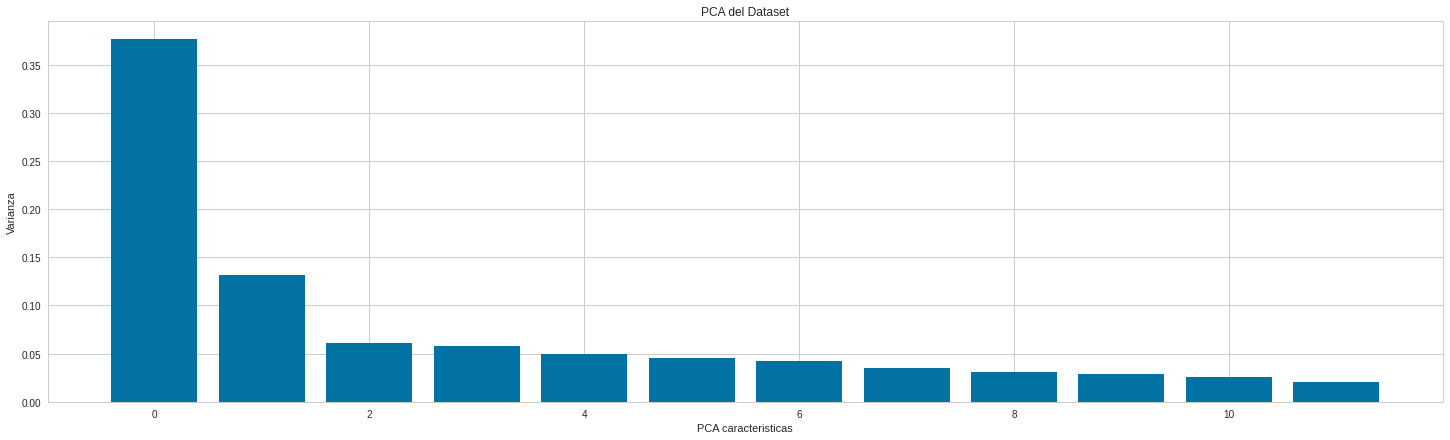

In [112]:
#reduccion de dimension
pca1 = PCA(0.90, whiten=True) # Keep 90% information
fit1 = pca1.fit(X)  # obtener los componentes principales

# Se grafica la varianza por cada caracteristica
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 
plt.xlabel('PCA caracteristicas')
plt.ylabel('Varianza')
plt.title('PCA del Dataset')

#Se plotea y se halla la varianza explicada
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

#otra manera de hacer el plot
#plt.plot(np.cumsum(pca1.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
#plt.show()

# Se transforma los datos del PCA
pca_data = pca1.transform(X)
pca_data = np.array(pca_data)
expl = pca1.explained_variance_ratio_
print(expl)
print ('suma:', sum(expl[0:10]))
print('Tamano del PCA: ', pca_data.shape)



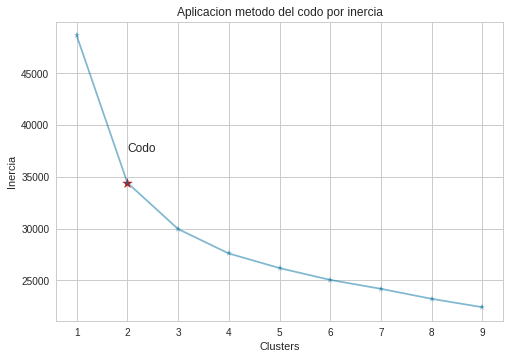

In [113]:

# Se obtiene el cluster de los datos
clusterData = datos.values

# Se estandarizan los datos
std_scale = StandardScaler().fit(clusterData)
clusterData = std_scale.transform(clusterData)

# Se hallan los K por medio del metodo de inercia
inertia = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
    kmeans.fit(clusterData)
    inertia.append(kmeans.inertia_)
    
codo = 2
plt.plot(range(1, 10), inertia, marker = '*', alpha=0.5)
plt.scatter(codo, inertia[codo-1], s=100, c='r', marker='*')
plt.title('Aplicacion metodo del codo por inercia')
plt.xlabel('Clusters')
plt.ylabel('Inercia')
plt.annotate('Codo' ,(codo, inertia[codo-1]), xytext=(codo,inertia[codo-1] + 3000))
plt.show()

Mean K:  4.0


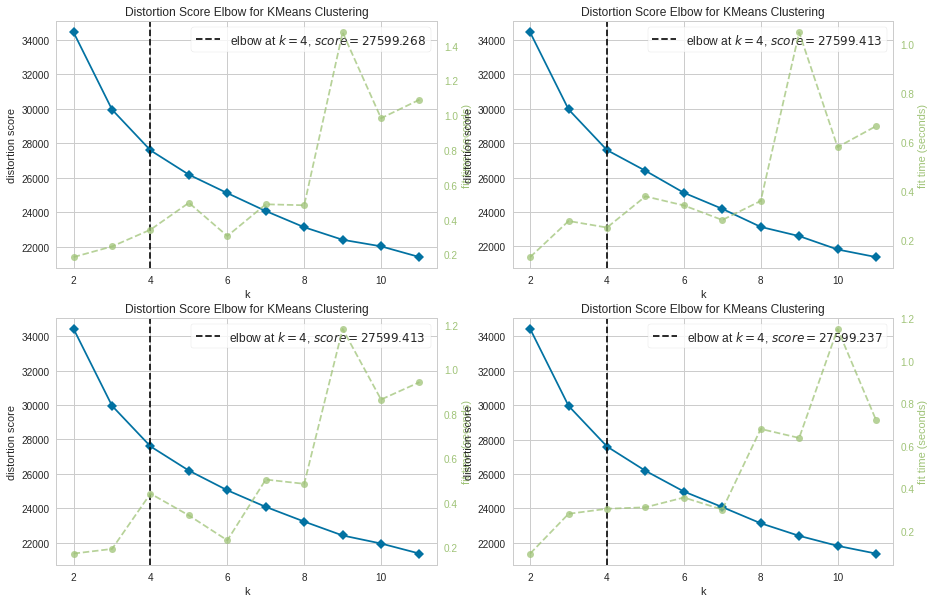

In [121]:
# Se inicializa la construccion del modelo de k-means clustering 
model = KMeans(init = 'k-means++')
klist = []

# Se realizan el metodo K-means 4 veces con diferentes clusters iniciales

#primero
plt.figure(figsize=(15,10))
plt.subplot(221)
grafica = KElbowVisualizer(model, k=(2,12), metric='distortion')
grafica.fit(clusterData)        #se ajustan los datos para ser visualizados
grafica.finalize()
klist.append(grafica.elbow_value_)

#segundo
plt.subplot(222)
grafica = KElbowVisualizer(model, k=(2,12), metric='distortion')
grafica.fit(clusterData)        #se ajustan los datos para ser visualizados
grafica.finalize()
klist.append(grafica.elbow_value_)

#tercero
plt.subplot(223)
grafica = KElbowVisualizer(model, k=(2,12), metric='distortion')
grafica.fit(clusterData)        #se ajustan los datos para ser visualizados
grafica.finalize()
klist.append(grafica.elbow_value_)

#cuarto
plt.subplot(224)
grafica = KElbowVisualizer(model, k=(2,12), metric='distortion')
grafica.fit(clusterData)        #se ajustan los datos para ser visualizados
grafica.finalize()
klist.append(grafica.elbow_value_)

print('Mean K: ', np.mean(klist))

In [123]:
#Teniendo en cuenta que por inercia el codo dio en K=2
#En distorcion dice que K=4
#Decidi usar K=4 que me parece más apropiado

# Se construye y ajusta el modelo K-Means 
kmeans = KMeans(n_clusters=4, init = 'k-means++').fit(clusterData)
pred = kmeans.predict(clusterData)
datos['Cluster'] = pred + 1

# Se rectifica el numero de datos en cada cluster
datos["Cluster"].value_counts()

2    609
1    580
3    514
4    509
Name: Cluster, dtype: int64

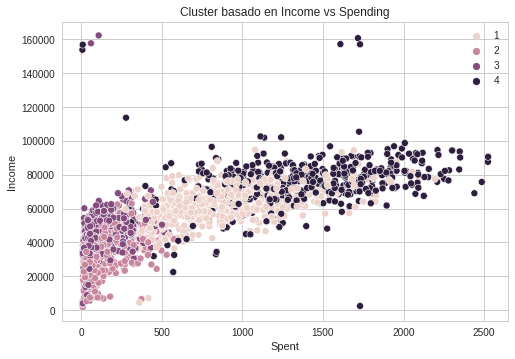

In [124]:
pl = sns.scatterplot(x='Spent', y='Income',hue='Cluster',data = datos)
pl.set_title("Cluster basado en Income vs Spending")
plt.legend()
plt.show()

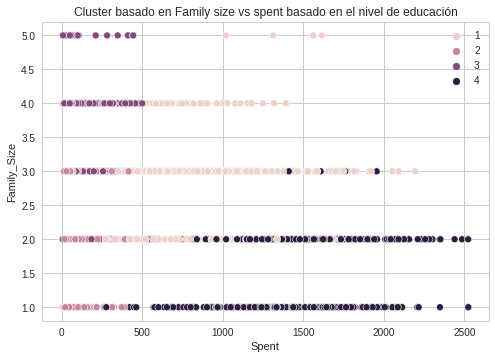

In [130]:
pl = sns.scatterplot(y='Family_Size', x='Spent',hue='Cluster',data = datos)
pl.set_title("Cluster basado en Family size vs spent basado en el nivel de educación")
plt.legend()
plt.show()

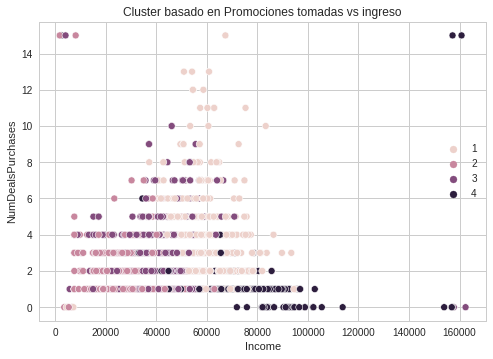

In [133]:
pl = sns.scatterplot(y='NumDealsPurchases', x='Income',hue='Cluster',data = datos)
pl.set_title("Cluster basado en Promociones tomadas vs ingreso")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

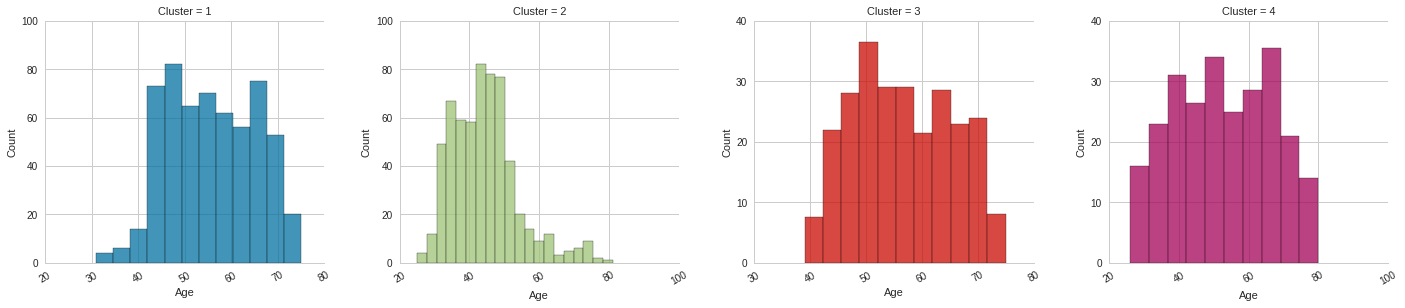

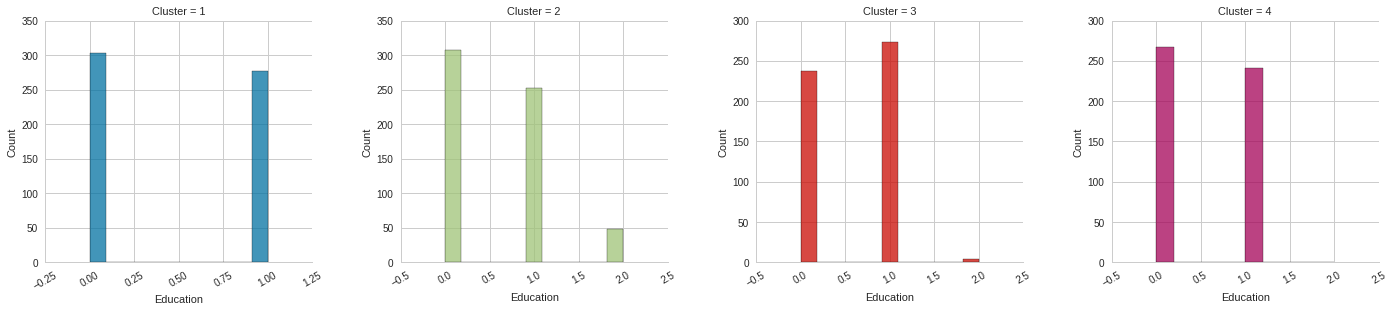

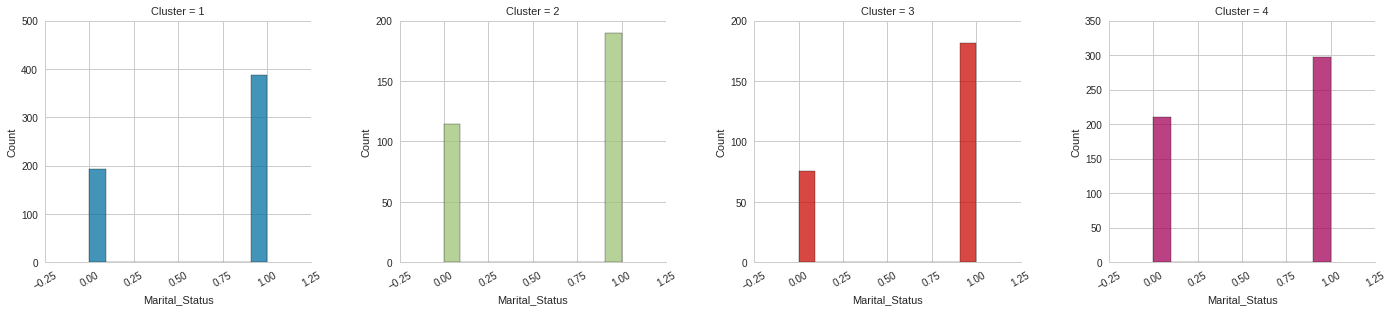

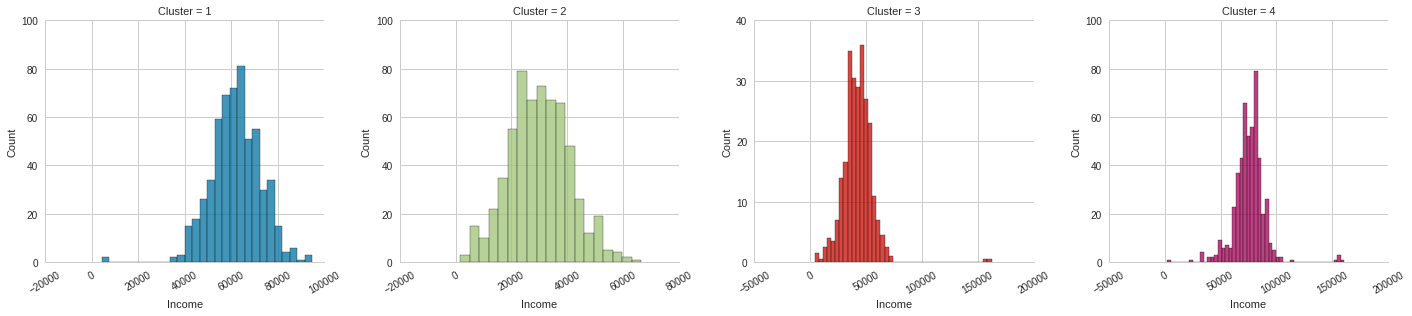

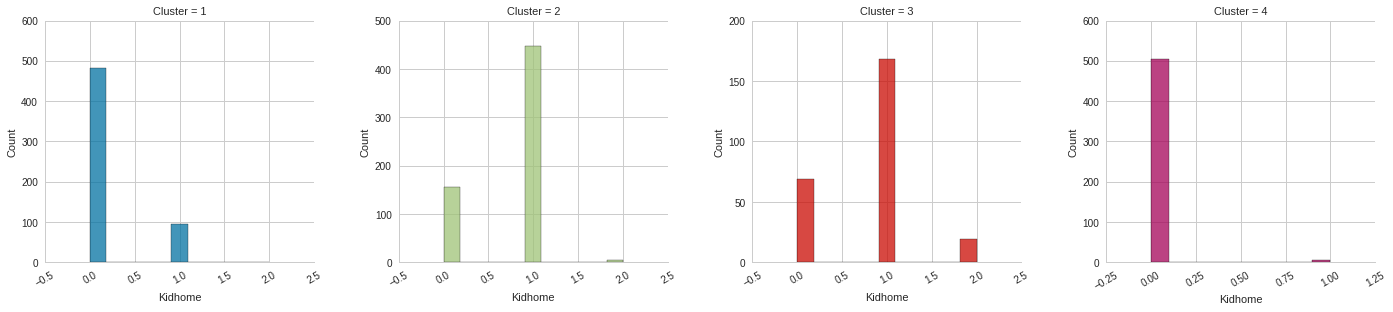

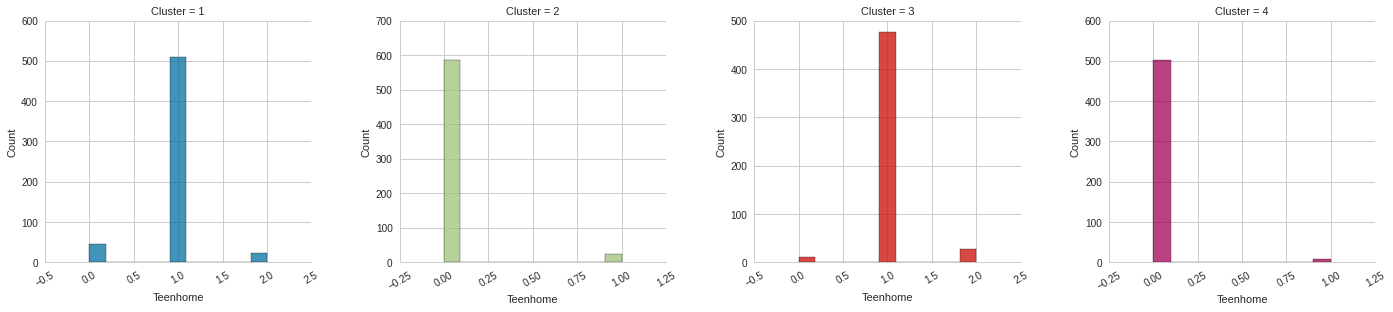

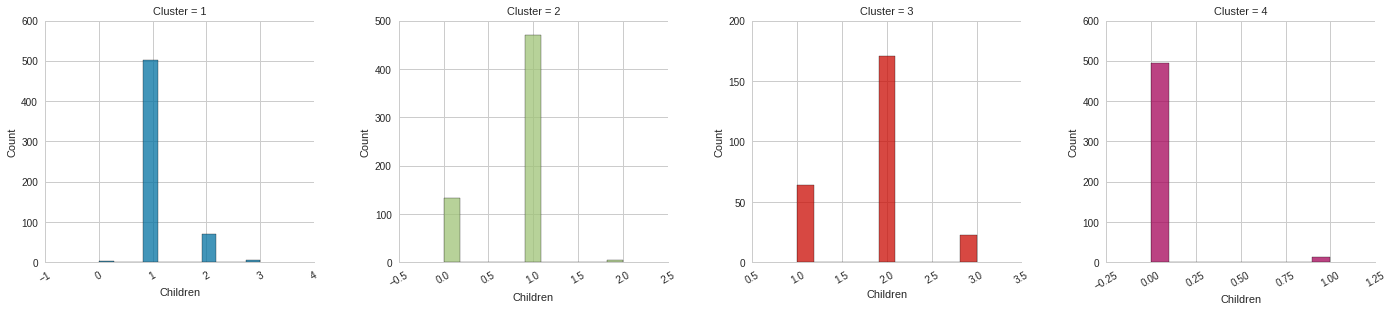

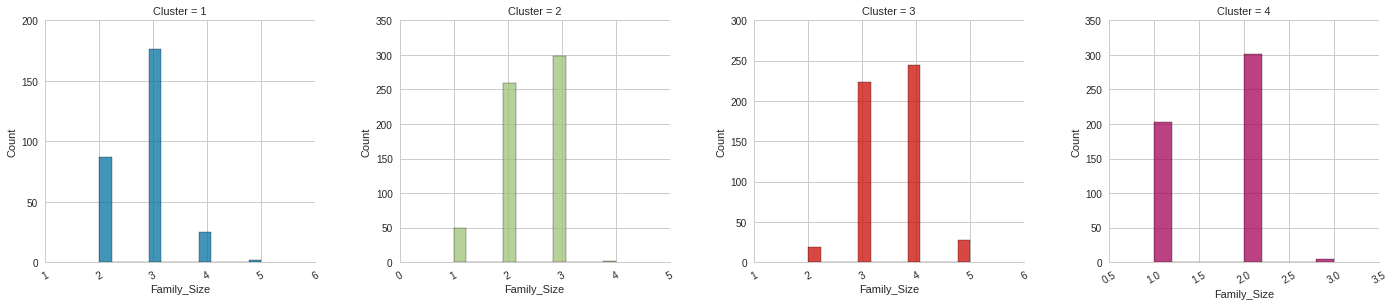

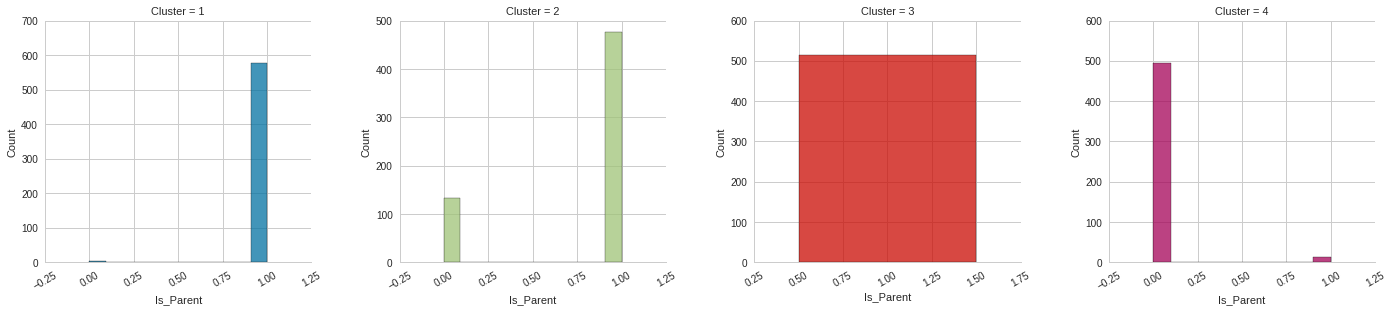

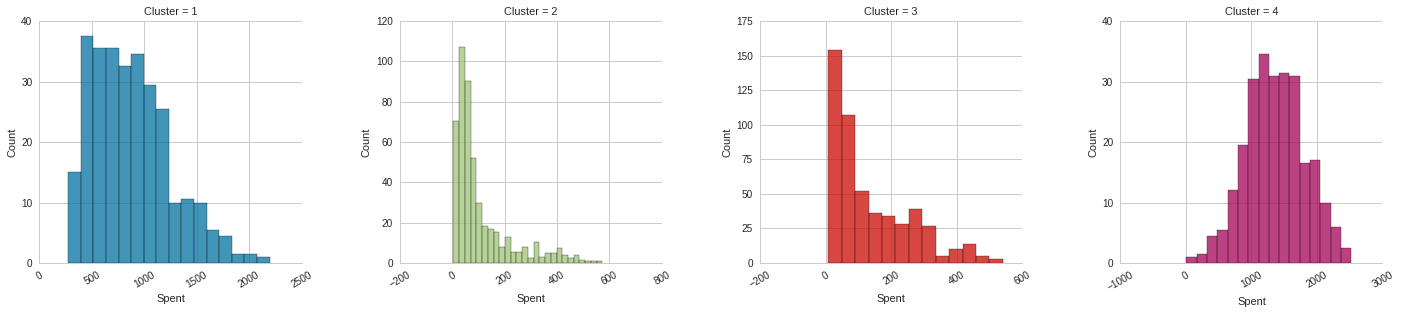

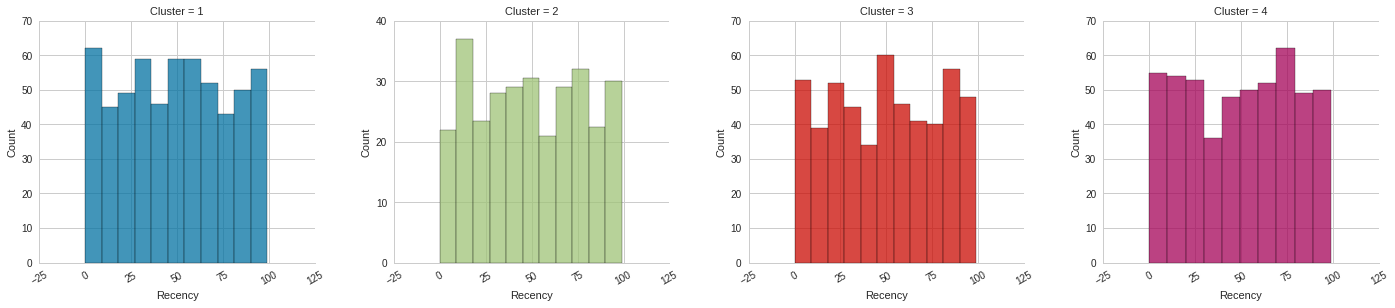

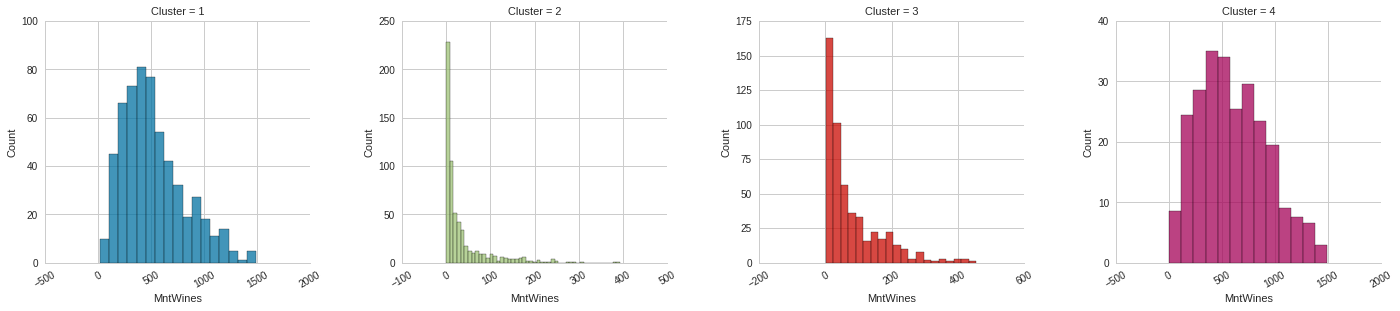

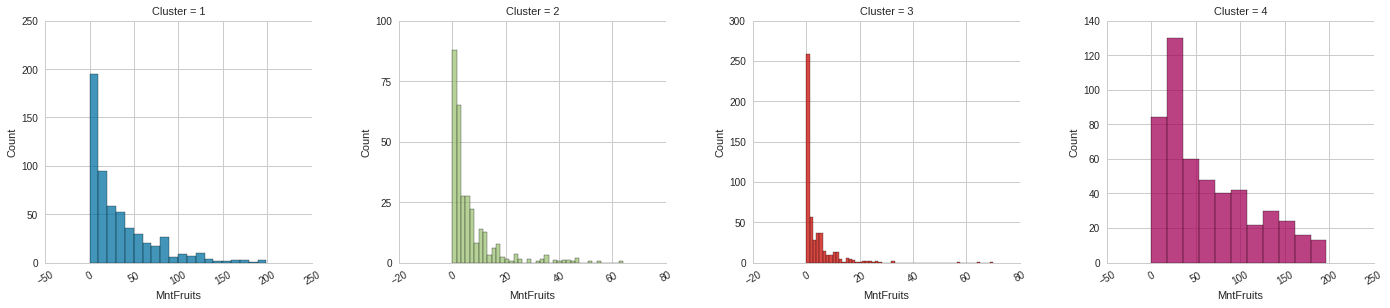

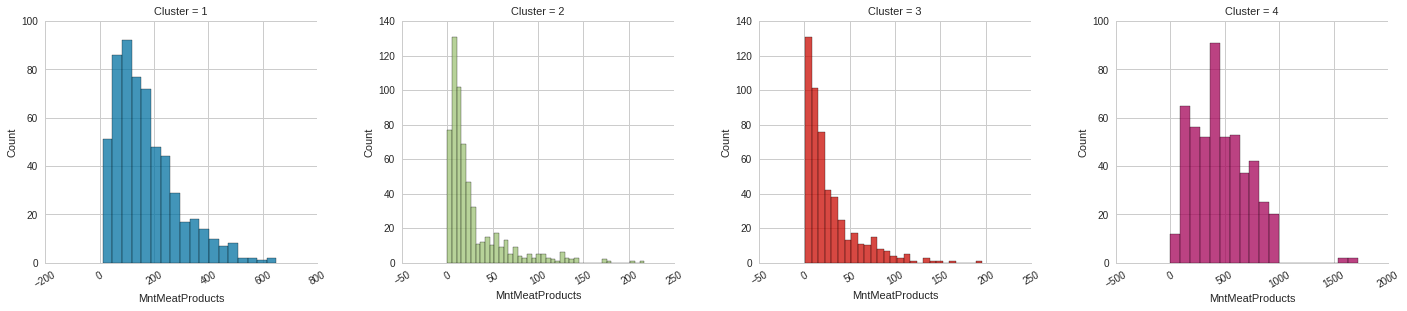

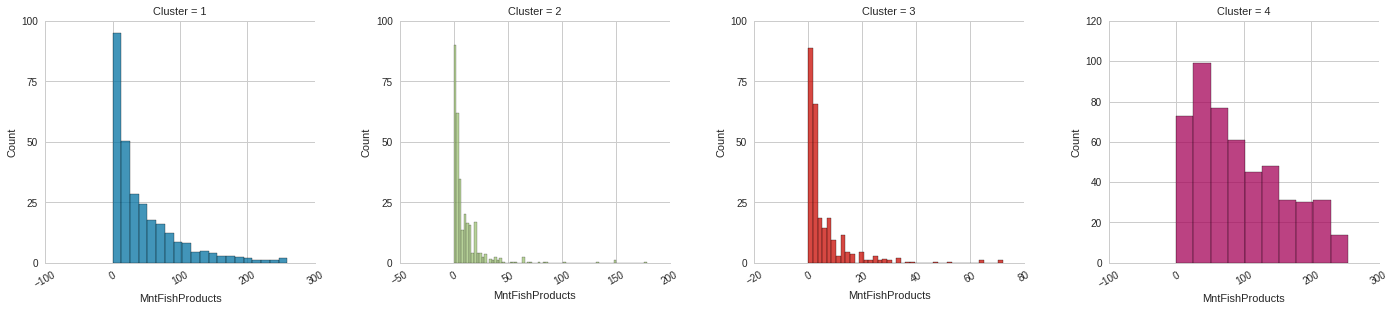

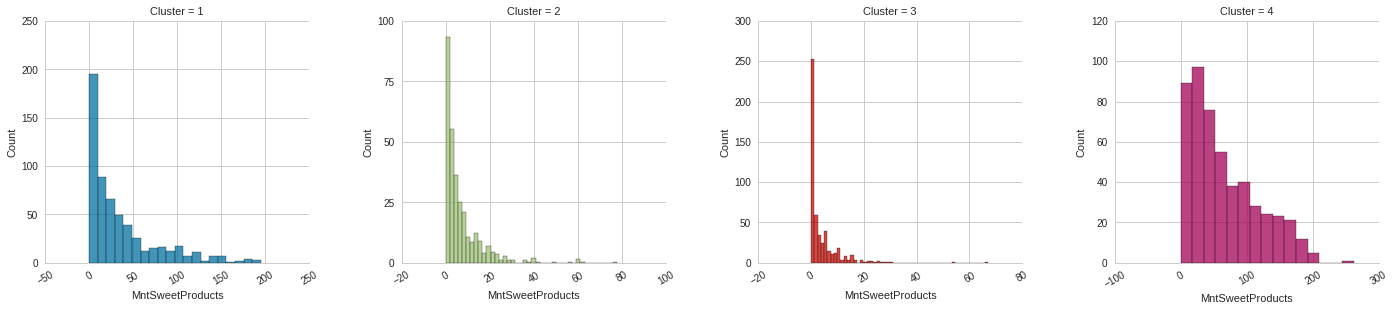

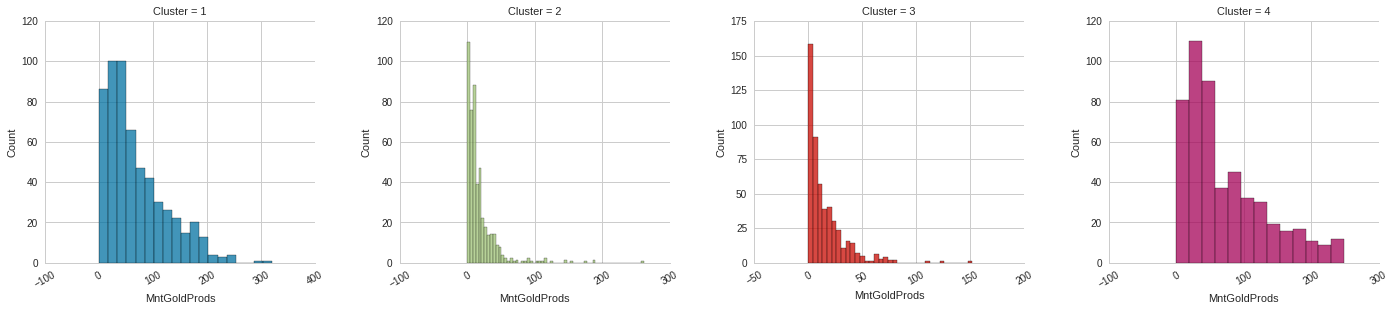

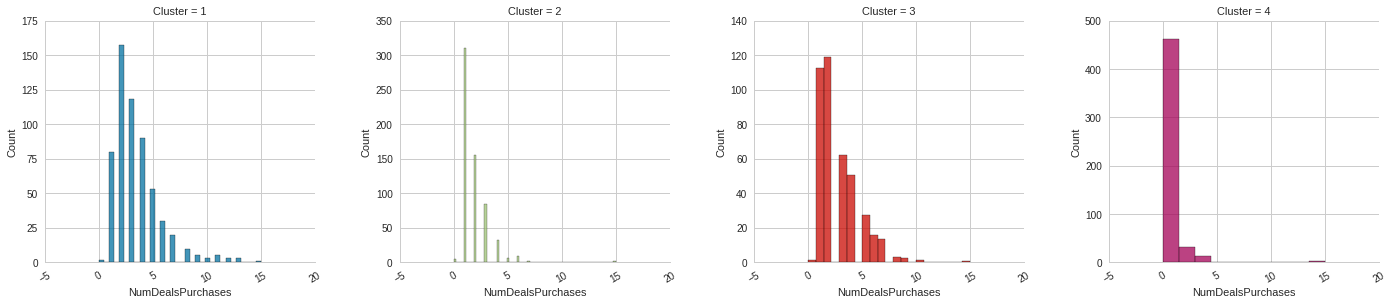

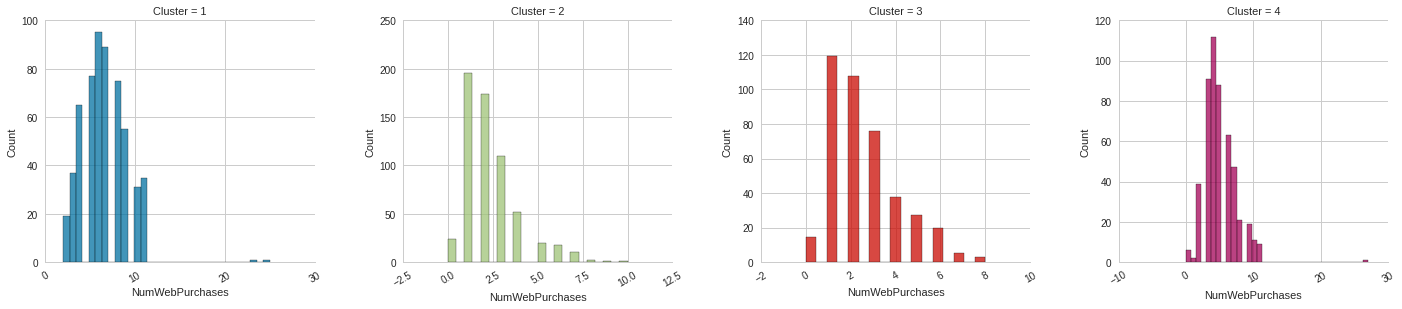

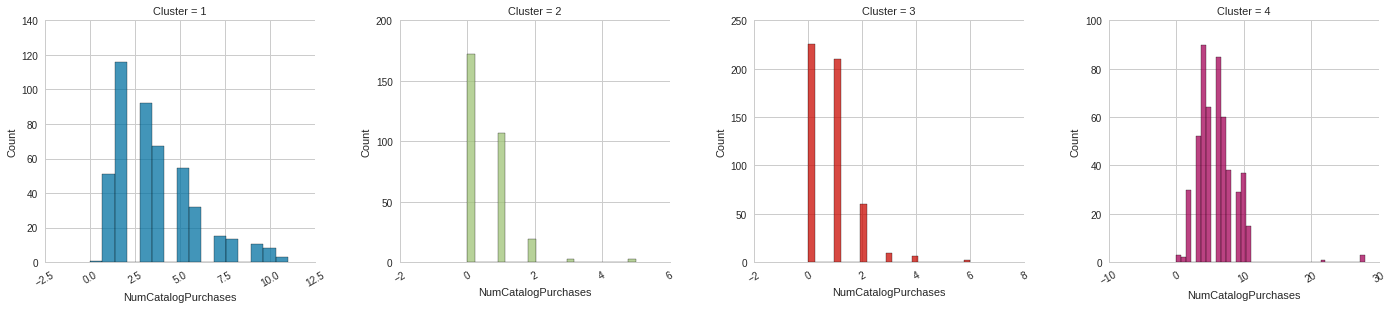

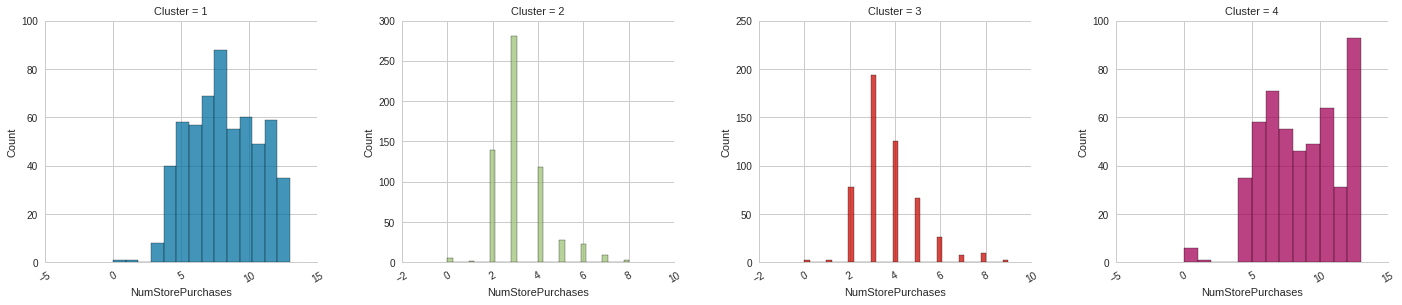

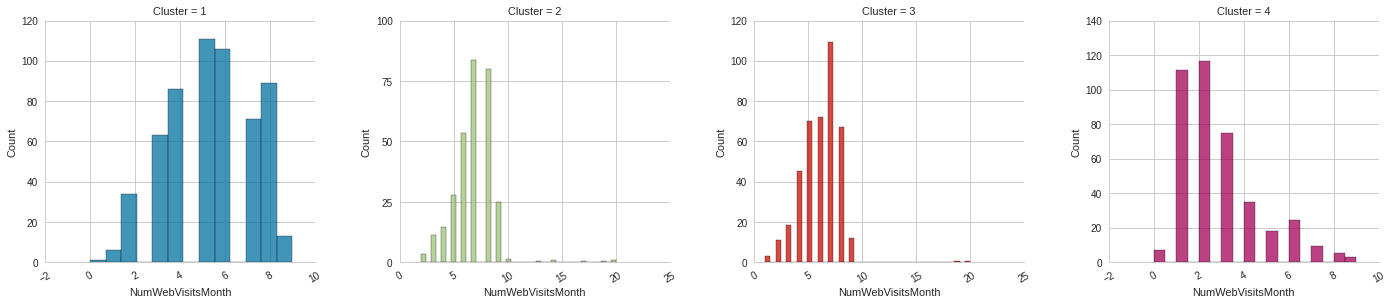

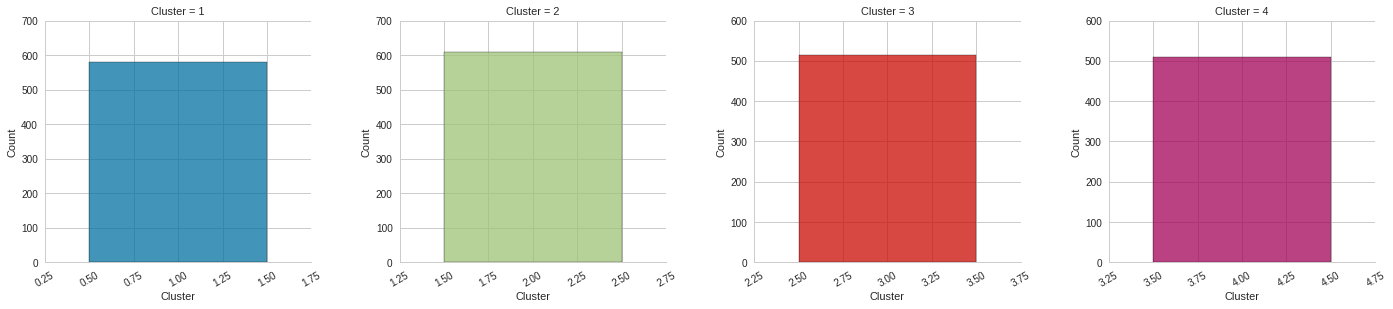

In [134]:

#Comparacion de clusters con todas las categorias

for i in datos:
    graf = sns.FacetGrid(datos, col = "Cluster", hue = "Cluster", sharey=False, sharex=False)
    graf.map(sns.histplot,i) 
    
    graf.set_xticklabels(rotation=30)
    graf.set_yticklabels()
    graf.fig.set_figheight(5)
    graf.fig.set_figwidth(20)
